# Dictionary learning on FC using just least squares and eigendecomp
The eigendecomp is only there to ensure dictionary is full of rank-1 connectivity matrices and not arbitrary (vectorized) matrices a.la. kSVD

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

847
(847, 264, 124)


In [22]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=-1, keepdims=True) for tsmod in ts]
print(ts[0].shape)

(847, 264, 124)


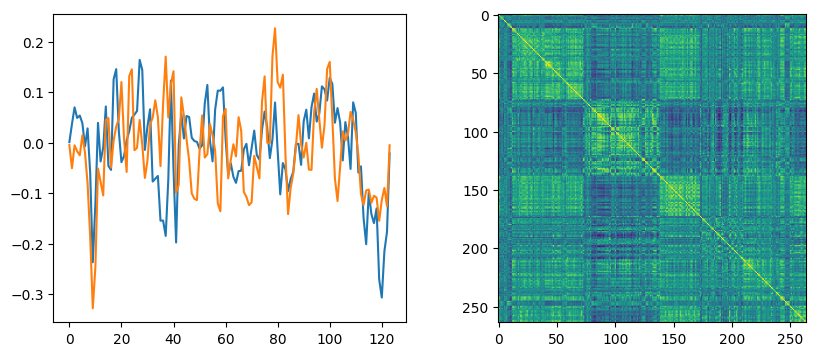

In [23]:
import matplotlib.pyplot as plt

p = np.corrcoef(ts[0][2])

fig, ax = plt.subplots(1,2,figsize=(10,4))

ax[0].plot(ts[0][0,0])
ax[0].plot(ts[0][0,74])
ax[1].imshow(p)
plt.show()

In [193]:
import torch
import random

xts = torch.from_numpy(ts[0]).float().cuda()

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

nsub = xts.shape[0]
nt = xts.shape[-1]

'''
Initialize dictionary
'''
ncodes = 1000
nuniq = round(265*264/2)
D = torch.zeros(nuniq,ncodes)
i,j = torch.triu_indices(264,264)
for c in range(ncodes):
    a = 1e-2*torch.randn(264,1)
    aa = a@a.T
    D[:,c] = aa[i,j]
D = D.float().cuda()

for _ in range(10):
    '''
    Estimate weights and get errors
    '''
    alpha1 = 1e-3*torch.eye(ncodes).float().cuda()
    E = torch.zeros(nsub*5,nuniq).float().cuda()
    W = torch.zeros(nsub*5,ncodes).float().cuda()
    for subidx,subts in enumerate(xts[0:nsub]):
        B = get_sub_fc(subts)
        B = B[i,j,:]
        subw, _, _, _ = torch.linalg.lstsq(D.T@D+alpha1,D.T@B)
        for ri in range(5):
            idx = random.randint(0,nt-1)
            E[5*subidx+ri] = ((B-D@subw)**2)[:,idx]
            W[5*subidx+ri] = subw[:,idx]

    print(torch.sum(B**2))
    print(torch.sum((B-D@subw)**2))
    print(torch.mean(E))
        
    '''
    Calculate dictionary
    '''
    alpha2 = 1e-3*torch.eye(ncodes).float().cuda()
    Gt, _, _, _ = torch.linalg.lstsq(W.T@W+alpha2,W.T@E) 
    D += 1*Gt.T

    '''
    Enforce rank-1 matrices for codes
    '''
#     H = torch.zeros(ncodes,264,264).float().cuda()
#     H[:,i,j] = D.T
#     H[:,j,i] = D.T
#     L, Q = torch.linalg.eigh(H)
#     d = L[:,0:1]*Q[:,0,:]
# #     print(torch.max(L))
#     D = torch.einsum('ci,cj->cij',d,d)
#     D = D[:,i,j]
#     D = D.T

print('Complete')
    

tensor(1224.8250, device='cuda:0')
tensor(1201.3218, device='cuda:0')
tensor(0.0002, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(556.3973, device='cuda:0')
tensor(6.5737e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(529.6673, device='cuda:0')
tensor(6.5461e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(512.5007, device='cuda:0')
tensor(6.9217e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(500.5210, device='cuda:0')
tensor(6.1517e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(490.8075, device='cuda:0')
tensor(5.9547e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(483.1831, device='cuda:0')
tensor(5.4692e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(477.5395, device='cuda:0')
tensor(5.5978e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(472.2582, device='cuda:0')
tensor(5.0615e-05, device='cuda:0')
tensor(1224.8250, device='cuda:0')
tensor(468.1488, device

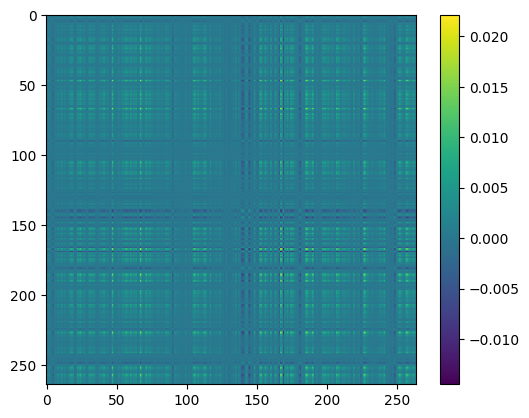

In [205]:
import matplotlib.pyplot as plt

tim = 10

fc = torch.zeros(264,264)
fc[i,j] = B[:,tim].detach().cpu()
fc[j,i] = B[:,tim].detach().cpu()
fc = fc.numpy()

fc1 = torch.zeros(264,264)
fc1[i,j] = (D@subw)[:,tim].detach().cpu()
fc1[j,i] = (D@subw)[:,tim].detach().cpu()
fc1 = fc1.numpy()

plt.imshow(fc)
plt.colorbar()
plt.show()

In [46]:
B[0:10,1]

tensor([ 0.0127,  0.0086, -0.0092,  0.0243,  0.0158, -0.0008, -0.0129, -0.0011,
        -0.0045,  0.0012], device='cuda:0')

In [49]:
(D@subw)[0:10,1]

tensor([ 2.0035e-03,  3.5398e-04, -2.4330e-04, -2.7579e-05,  1.4629e-04,
        -5.6163e-04, -3.1644e-05,  1.2935e-04,  1.6175e-04,  1.3803e-04],
       device='cuda:0')